# MLP

Same as MLP 18 but use scaling. 

Noncoding RNA. MLP with one neuron. All K-mers, K=4, one byte counts with cap 255. Threshold=mean (fair test, not Gudenas). Scaling. 5-fold CV. RCI from cell line 0 = A549.

Cross validation acc mean 56.52% (+/- 4.53%) on binary classification of all lncRNA.

We used 20 epochs but 5 might suffice. Accuracy declined after about 5 epochs.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-21 09:17:44.422495
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=20
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_noncoding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_noncoding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-21 09:17:56.949090
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-21 09:17:56.957445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-21 09:17:57.131367
Loaded values for cell line 0
Selected 1422 values out of 4622
2022-10-21 09:17:58.065450


## Train and validate with all K-mer counts

In [8]:
SCALING = True
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes,'mean')
        X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholds)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Thresholds',thresholds)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-21 09:17:58.118813
2022-10-21 09:17:58.119289
splitting
scaling
2022-10-21 09:17:58.155504
Fold 1
Train sizes 5223 5223
Valid sizes 1534 1534
Thresholds (-0.4618886470474517, -0.4618886470474517)
Train set ones/size 3411 / 5223
Valid set ones/size 744 / 1534
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:17:58.228346
Epoch 1/20
164/164 [==============================] - 1s 4ms/step - loss: 0.7253 - accuracy: 0.5497 - val_loss: 0.7674 - val_accuracy: 0.4922
Epoch 2/20
164/164 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6178 - val_loss: 0.7776 - val_accuracy: 0.4648
Epoch 3/20
164/164 [==============================] - 1s 4ms/step - loss: 0.6249 - accuracy: 0.6626 - val_loss: 0.7746 - val_accuracy: 0.4635
Epoch 4/20
164/164 [==============================] - 1s 4ms/step - loss: 0.6017 - accuracy: 0.6902 - val_loss: 0.7907 - val_accuracy: 0.4628
Epoch 5/20
164/164 [==============================] - 0s 3ms/step - loss: 0.5860 - accuracy: 0.7061

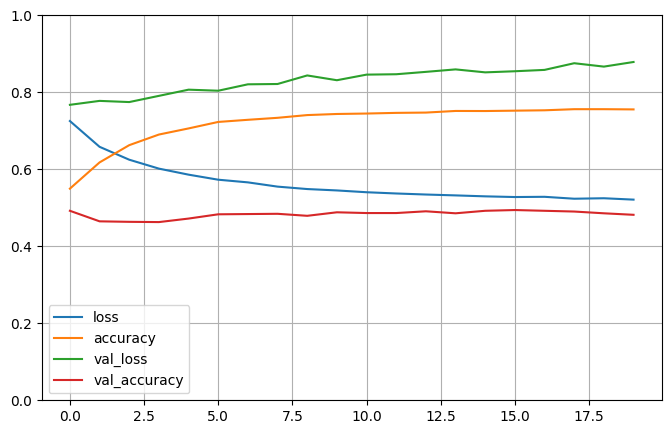

Compute valiation accuracy
2022-10-21 09:18:08.526275
accuracy: 48.17%
2022-10-21 09:18:08.636134
scaling
2022-10-21 09:18:08.651790
Fold 2
Train sizes 5673 5673
Valid sizes 1084 1084
Thresholds (-0.4754613112917399, -0.4754613112917399)
Train set ones/size 3508 / 5673
Valid set ones/size 652 / 1084
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:18:08.708906
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6990 - accuracy: 0.5738 - val_loss: 0.7193 - val_accuracy: 0.5747
Epoch 2/20
178/178 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6438 - val_loss: 0.6836 - val_accuracy: 0.5867
Epoch 3/20
178/178 [==============================] - 0s 2ms/step - loss: 0.6149 - accuracy: 0.6801 - val_loss: 0.6906 - val_accuracy: 0.6107
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5929 - accuracy: 0.7021 - val_loss: 0.6827 - val_accuracy: 0.5886
Epoch 5/20
178/178 [==============================] - 0s 2ms/step

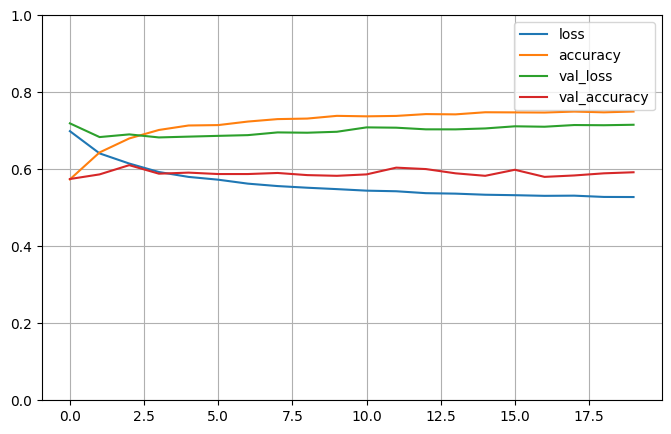

Compute valiation accuracy
2022-10-21 09:18:18.118688
accuracy: 59.23%
2022-10-21 09:18:18.207825
scaling
2022-10-21 09:18:18.223252
Fold 3
Train sizes 5292 5292
Valid sizes 1465 1465
Thresholds (-0.45677917384885763, -0.45677917384885763)
Train set ones/size 3085 / 5292
Valid set ones/size 1068 / 1465
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:18:18.260849
Epoch 1/20
166/166 [==============================] - 1s 3ms/step - loss: 0.7102 - accuracy: 0.5497 - val_loss: 0.6990 - val_accuracy: 0.6430
Epoch 2/20
166/166 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6285 - val_loss: 0.6532 - val_accuracy: 0.6771
Epoch 3/20
166/166 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.6625 - val_loss: 0.6574 - val_accuracy: 0.6532
Epoch 4/20
166/166 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.6850 - val_loss: 0.6529 - val_accuracy: 0.6601
Epoch 5/20
166/166 [==============================] - 0s 2ms/s

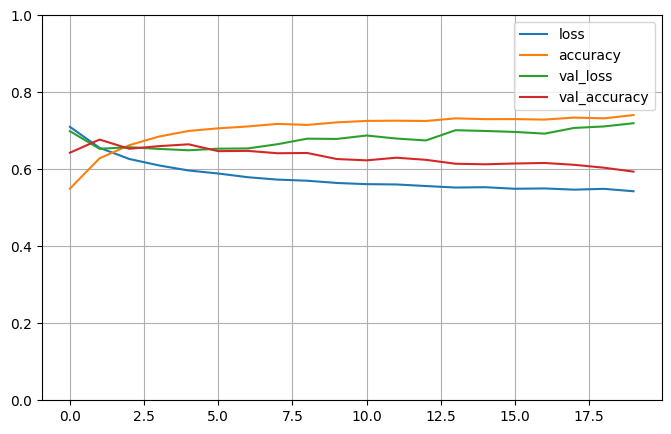

Compute valiation accuracy
2022-10-21 09:18:28.336091
accuracy: 59.39%
2022-10-21 09:18:28.465168
scaling
2022-10-21 09:18:28.483407
Fold 4
Train sizes 5470 5470
Valid sizes 1287 1287
Thresholds (-0.4807138250790861, -0.4807138250790861)
Train set ones/size 3345 / 5470
Valid set ones/size 818 / 1287
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:18:28.547525
Epoch 1/20
171/171 [==============================] - 1s 3ms/step - loss: 0.6816 - accuracy: 0.5901 - val_loss: 0.7600 - val_accuracy: 0.4848
Epoch 2/20
171/171 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.6570 - val_loss: 0.7313 - val_accuracy: 0.5524
Epoch 3/20
171/171 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.6962 - val_loss: 0.7184 - val_accuracy: 0.5579
Epoch 4/20
171/171 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.7139 - val_loss: 0.7165 - val_accuracy: 0.5726
Epoch 5/20
171/171 [==============================] - 0s 2ms/step

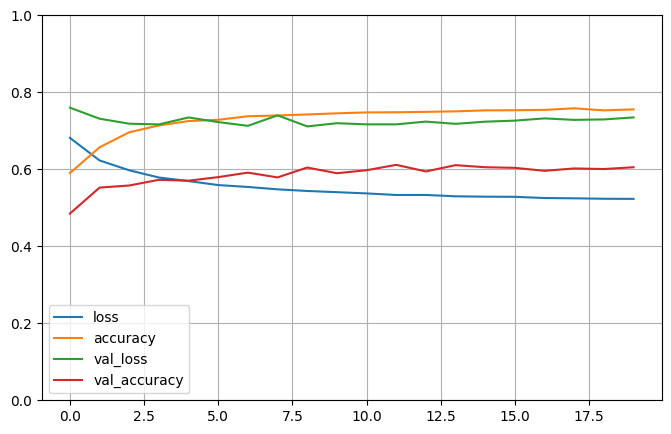

Compute valiation accuracy
2022-10-21 09:18:37.323221
accuracy: 60.53%
2022-10-21 09:18:37.454756
scaling
2022-10-21 09:18:37.473511
Fold 5
Train sizes 5377 5377
Valid sizes 1380 1380
Thresholds (-0.4927765818892794, -0.4927765818892794)
Train set ones/size 3361 / 5377
Valid set ones/size 921 / 1380
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:18:37.523040
Epoch 1/20
169/169 [==============================] - 1s 4ms/step - loss: 0.7079 - accuracy: 0.5708 - val_loss: 0.6763 - val_accuracy: 0.5616
Epoch 2/20
169/169 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.6357 - val_loss: 0.6602 - val_accuracy: 0.5986
Epoch 3/20
169/169 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6749 - val_loss: 0.6560 - val_accuracy: 0.6297
Epoch 4/20
169/169 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.6898 - val_loss: 0.6647 - val_accuracy: 0.6239
Epoch 5/20
169/169 [==============================] - 0s 3ms/step

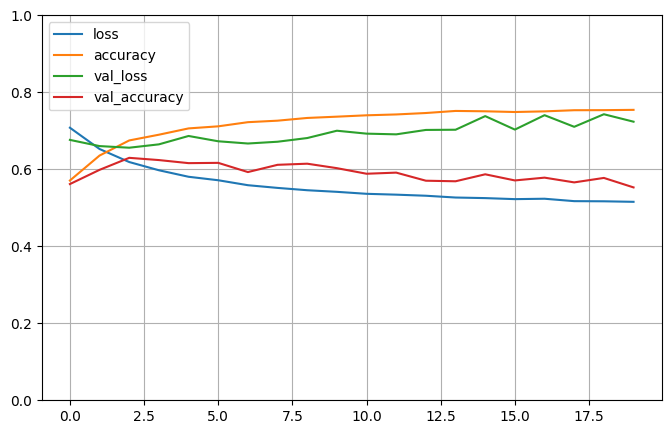

Compute valiation accuracy
2022-10-21 09:18:47.518362
accuracy: 55.29%
2022-10-21 09:18:47.620643

Cross validation acc mean 56.52% (+/- 4.53%)
2022-10-21 09:18:47.624590


In [9]:
print(datetime.now())
do_cross_validation(splitter,EPOCHS)    
print(datetime.now())